In [4]:
# Paso 0: Importar librerias necesarias

import warnings
warnings.simplefilter('ignore')

import pandas as pd
import numpy as np
import pylab as plt
from pandas.plotting import lag_plot


In [5]:
# Paso 1: Importar el DF de todas las empresas del IBEX 35

df = pd.read_csv('ibex35.csv')

df.head()

,id,ticker,empresa,date,open,high,low,close,adj close,volume
0,1,ANA,Acciona,2019-01-02,73.900002,73.900002,73.900002,73.900002,64.148270,0
1,1,ANA,Acciona,2022-06-24,174.199997,178.800003,174.000000,178.800003,169.562302,0
2,1,ANA,Acciona,2022-06-23,169.899994,173.199997,169.000000,173.000000,164.061951,0
3,1,ANA,Acciona,2022-06-22,171.399994,171.399994,168.800003,170.199997,161.406616,0
4,1,ANA,Acciona,2022-06-21,179.699997,179.699997,172.300003,173.600006,164.630966,0


In [6]:
# Paso 2: Filtrar por la empresa sobre la que realizar el modelo

colonial = df[df['empresa'] == 'Colonial Inmobiliaria']

colonial.shape

(1325, 10)

In [7]:
# Paso 3: Seleccionar las columnas definitivas que utilizaremos

colonial = colonial [['date','open','high','low','close','adj close']]

colonial.shape

(1325, 6)

In [8]:
# Paso 4: Modificar el formato de columna 'date' (format: object ===> datatime)

colonial['date'] = pd.to_datetime(colonial['date'], format="%Y-%m-%d")

colonial.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1325 entries, 27175 to 28499
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1325 non-null   datetime64[ns]
 1   open       1325 non-null   float64       
 2   high       1325 non-null   float64       
 3   low        1325 non-null   float64       
 4   close      1325 non-null   float64       
 5   adj close  1325 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 72.5 KB


In [9]:
# Paso 5: Ordenar el DF por fecha

colonial.sort_values(by='date',ascending= True, inplace=True)

colonial.head()

,date,open,high,low,close,adj close
27623,2019-01-02,7.95,8.065,7.885,8.020,6.861066
27622,2019-01-03,8.02,8.085,7.990,8.040,6.878175
27621,2019-01-04,8.10,8.185,8.040,8.175,6.993667
27620,2019-01-07,8.20,8.305,8.140,8.295,7.096326
27619,2019-01-08,8.32,8.540,8.255,8.465,7.241761


In [10]:
# Paso 6: Filtrar nuevamente para eliminar efecto COVID del análisis (previo a 2021)

# Filtro:

fecha_inicio = '2021-01-01'
fecha_fin = '2024-03-01'

colonial = colonial[(colonial['date'] >= fecha_inicio) & (colonial['date'] <= fecha_fin)]

# Comprobar si se ha aplicado correctamente

colonial.shape

(812, 6)

In [11]:
# Paso 7: Añadir al DF fechas obviadas por mercado de valores español (fin de semana y festivos)

# Rango de fechas desde '2021-01-01' a '2024-03-01'

date_range = pd.date_range(start=colonial['date'].min(), end=colonial['date'].max(), freq='D')

# Reindexa el DF con el nuevo rango de fechas

colonial = colonial.set_index('date').reindex(date_range).reset_index()

# Volver a modificar el nombre de columna 'date'

colonial = colonial.rename(columns={'index': 'date'})


In [12]:
# Paso 8: Comprobar que ha introducido la fechas ausentes en el DF original

colonial.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,8.060,8.125,7.870,7.965,7.130009
1,2021-01-05,7.975,8.005,7.835,7.990,7.152387
2,2021-01-06,7.935,8.100,7.875,8.030,7.188194
3,2021-01-07,8.100,8.100,7.860,7.940,7.107630
4,2021-01-08,7.880,7.975,7.820,7.940,7.107630
5,2021-01-09,NaN,NaN,NaN,NaN,NaN
6,2021-01-10,NaN,NaN,NaN,NaN,NaN
7,2021-01-11,7.875,7.995,7.800,7.815,6.995734
8,2021-01-12,7.855,7.915,7.770,7.840,7.018113
9,2021-01-13,7.770,8.010,7.770,7.970,7.134484


In [13]:
# Paso 9: Rellenar valores nulos con el anterior valor de la columna(viernes o previo a festivo)

colonial = colonial.fillna(method='ffill')

In [14]:
# Paso 10: Comprobar que se han introducido los valores correctamente


colonial.head(10)

,date,open,high,low,close,adj close
0,2021-01-04,8.060,8.125,7.870,7.965,7.130009
1,2021-01-05,7.975,8.005,7.835,7.990,7.152387
2,2021-01-06,7.935,8.100,7.875,8.030,7.188194
3,2021-01-07,8.100,8.100,7.860,7.940,7.107630
4,2021-01-08,7.880,7.975,7.820,7.940,7.107630
5,2021-01-09,7.880,7.975,7.820,7.940,7.107630
6,2021-01-10,7.880,7.975,7.820,7.940,7.107630
7,2021-01-11,7.875,7.995,7.800,7.815,6.995734
8,2021-01-12,7.855,7.915,7.770,7.840,7.018113
9,2021-01-13,7.770,8.010,7.770,7.970,7.134484


In [15]:
# Paso 11: Establecer columna 'date' como índice para modelo

colonial = colonial.set_index('date')

colonial.head(10)

,open,high,low,close,adj close
date,,,,,
2021-01-04,8.060,8.125,7.870,7.965,7.130009
2021-01-05,7.975,8.005,7.835,7.990,7.152387
2021-01-06,7.935,8.100,7.875,8.030,7.188194
2021-01-07,8.100,8.100,7.860,7.940,7.107630
2021-01-08,7.880,7.975,7.820,7.940,7.107630
2021-01-09,7.880,7.975,7.820,7.940,7.107630
2021-01-10,7.880,7.975,7.820,7.940,7.107630
2021-01-11,7.875,7.995,7.800,7.815,6.995734
2021-01-12,7.855,7.915,7.770,7.840,7.018113


In [16]:
# Paso 12: Establecer siguiente criterio para que el modelo AR funcione

colonial.index = pd.DatetimeIndex(colonial.index).to_period('d')

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

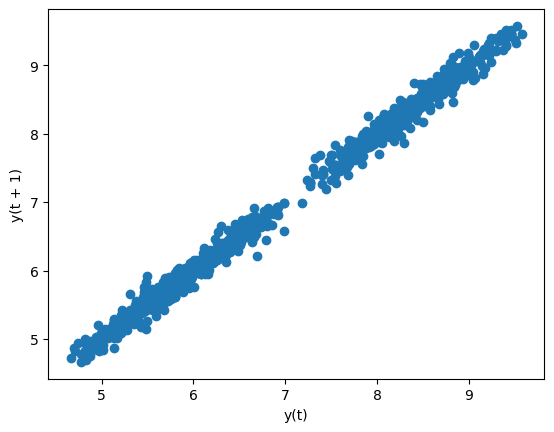

In [17]:
# Paso 13: Comprobar linealidad de la variable y = 'close'

lag_plot(colonial.close)

In [18]:
# Paso 14: Importar modelo de AR

from statsmodels.tsa.ar_model import AutoReg as AR

In [19]:
# Paso 15: Realizar el split en el DF del train y el test

train, test = colonial.close[:-10], colonial.close[-10:]

train.shape, test.shape

((1143,), (10,))

In [20]:
# Paso 16: Entrenar el modelo de AR

modelo = AR(train, lags=1).fit()

In [21]:
# Paso 17: Realizar predicción con el entrenamiento

pred = modelo.predict(len(train), len(colonial.close)-1)

# Check sobre los valores de la predicción

pred

2024-02-21    5.131498
2024-02-22    5.132993
2024-02-23    5.134484
2024-02-24    5.135972
2024-02-25    5.137457
2024-02-26    5.138939
2024-02-27    5.140418
2024-02-28    5.141893
2024-02-29    5.143365
2024-03-01    5.144834
Freq: D, dtype: float64

In [22]:
# Paso 18: Chequear coincidencia entre test y pred

test

date
2024-02-21    5.12
2024-02-22    5.15
2024-02-23    5.12
2024-02-24    5.12
2024-02-25    5.12
2024-02-26    5.12
2024-02-27    5.19
2024-02-28    5.07
2024-02-29    5.02
2024-03-01    4.91
Freq: D, Name: close, dtype: float64

In [23]:
# Paso 19: Calcular el error de la predicción sobre la realidad

error = (pred - test).abs().sum()/len(pred)  

error

0.05750331011951708

In [24]:
# Paso 20: Generar un DF sobre la comparativa en realidad, predicción y error

res=pd.DataFrame({'real': test, 'pred': pred, 'error': pred - test})

res

,real,pred,error
2024-02-21,5.12,5.131498,0.011498
2024-02-22,5.15,5.132993,-0.017007
2024-02-23,5.12,5.134484,0.014484
2024-02-24,5.12,5.135972,0.015972
2024-02-25,5.12,5.137457,0.017457
2024-02-26,5.12,5.138939,0.018939
2024-02-27,5.19,5.140418,-0.049582
2024-02-28,5.07,5.141893,0.071893
2024-02-29,5.02,5.143365,0.123365
2024-03-01,4.91,5.144834,0.234834
